# Check_raw_data_deployment

Notebook used to check the raw data coming from one deployment and see if everything is correct before processing them and to use them:
1. Sensors extrinsic calibration values
2. Static GCP calibration result and accuracy
3. Robotic total stations data
4. GNSS data

Files of raw data are saved in the repository of the deployment.


In [1]:
import numpy as np
import sys
import os
sys.path.append("../")
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_utils as theodo_u
import scripts.theodolite_plot_function as theodo_p
import scripts.theodolite_function as theodo_f

# Important: set path to deployment data
path = "../data/20230725-1/"

/opt/homebrew/lib/python3.10/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/opt/homebrew/lib/python3.10/site-packages/fdm/fdm.py:44: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  / np.math.factorial(order)
/opt/homebrew/lib/python3.10/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/opt/homebrew/lib/python3.10/site-packages/fdm/fdm.py:44: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
 

# 1. Sensors extrinsic calibration results

In [2]:
# Function to read sensors extrinsic calibration file and see the inter-prism and inter-GNSS distance (if GNSS was used during the deployment)
theodo_u = importlib.reload(theodo_u)
extrinsic_calibration_results = theodo_u.read_extrinsic_calibration_results_file(path+"sensors_extrinsic_calibration/calibration_results.csv")
print("Inter-prism distance measured [m]: ", extrinsic_calibration_results[0:3])
if(len(extrinsic_calibration_results)>3):
    print("Inter-GNSS distance measured [m]: ", extrinsic_calibration_results[3:6])

Inter-prism distance measured [m]:  [1.03304543784065, 0.6211003440288285, 0.8298205414855501]
Inter-GNSS distance measured [m]:  [1.0232781964393043, 0.5832249618085531, 0.8652673149776331]


# 2. Static GCP calibration result and accuracy


Average error during the calibration:  3.798 mm


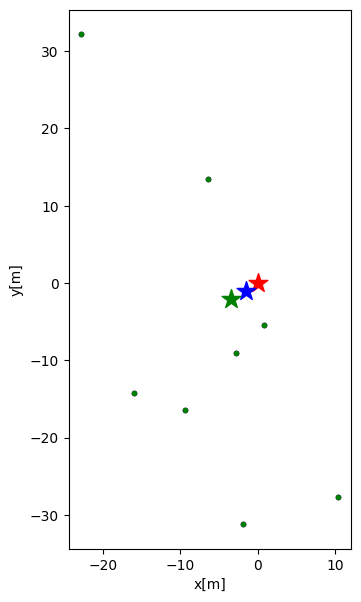

In [3]:
# Function used to show the resection accuracy
# Read markers file of grand axe and show them

theodo_u = importlib.reload(theodo_u)
theodo_p = importlib.reload(theodo_p)

path_file_GCP = "total_stations/GCP.txt"
file_name = path+path_file_GCP

trimble_1_gcp, trimble_2_gcp, trimble_3_gcp, T_1_grand, T_2_grand, T_3_grand = theodo_u.read_marker_file(file_name, 1, 1)

tp1 = T_1_grand@trimble_1_gcp
tp2 = T_2_grand@trimble_2_gcp
tp3 = T_3_grand@trimble_3_gcp

save_tf = False
name_file = path + "list_tf/TF_list_static_cp.csv"
if(save_tf):
    theodo_u.save_tf(T_1_grand, T_2_grand, T_3_grand, name_file)

error = []
for i,j,k in zip(tp1[0:3],tp2[0:3],tp3[0:3]):
    dist_12 = np.linalg.norm(i-j)
    dist_13 = np.linalg.norm(i-k)
    dist_23 = np.linalg.norm(k-j)
    error.append(dist_12)
    error.append(dist_13)
    error.append(dist_23)
print("Average error during the calibration: ", round(np.mean(error)*1000,3), "mm")

plot_3d = 0   # Variable to plot in 3d, 0 = 2D, 1 = 3D
save_pdf = 0   # Variable to save file in pdf
file_pdf = path + "figures/GCP_calibration_result.pdf"   # file name to save plot in pdf
theodo_p.plot_trajectories_prism(3, tp1, tp2, tp3, T_1_grand, T_2_grand, T_3_grand, plot_3d, save_pdf,file_pdf,1)

# 3. Robotic total stations data

TODO before :
compile rosbags with this node https://github.com/norlab-ulaval/theodolite_node_msgs

In [8]:
# Read rosbag of grand axe and show the trajectory
from pathlib import Path
%matplotlib notebook
theodo_u = importlib.reload(theodo_u)
theodo_p = importlib.reload(theodo_p)

# Important: change path to rosbag
# file = "/home/maxime/data/FR2023/20230518/2023-05-18-10-46-34.bag"
file = "/Volumes/T7/data/2023-07-25-14-53-26.bag"

Tf = []
# T_1_grand = np.identity(4)
# T_2_grand = np.identity(4)
# T_3_grand = np.identity(4)
Tf.append(T_1_grand)
Tf.append(T_2_grand)
Tf.append(T_3_grand)
trajectory_trimble_1, trajectory_trimble_2, trajectory_trimble_3, time_trimble_1, time_trimble_2, time_trimble_3 = theodo_u.read_rosbag_theodolite_with_tf(file, Tf, msg_node_dir=Path.cwd()/"../msgs/theodolite_node_msgs")
trimble_1 = np.array(trajectory_trimble_1).T
trimble_2 = np.array(trajectory_trimble_2).T
trimble_3 = np.array(trajectory_trimble_3).T

%matplotlib notebook
plot_3d = 0   # Variable to plot in 3d, 0 = 2D, 1 = 3D
save_pdf = 1   # Variable to save file in pdf
file_pdf = path + "figures/trajectories_without_legend.png"   # file name to save plot in pdf
theodo_p.plot_trajectories_prism_GCP(3, trimble_1, trimble_2, trimble_3, T_1_grand, T_2_grand, T_3_grand, trimble_1_gcp, plot_3d, save_pdf, file_pdf, 1)
file_pdf = path + "figures/Raw_data_TS.png"   # file name to save plot in pdf
theodo_p.plot_trajectories_prism(3, trimble_1, trimble_2, trimble_3, T_1_grand, T_2_grand, T_3_grand, plot_3d, save_pdf, file_pdf, 1)

# Convert point data to csv file
# Trajectory total station (time, point data) x3
if(save_pdf==1):
    theodo_u.Convert_raw_data_TS_with_GCP_calibration_to_csv(time_trimble_1, np.array(trimble_1).T, path + "total_stations/trimble1.csv")
    theodo_u.Convert_raw_data_TS_with_GCP_calibration_to_csv(time_trimble_2, np.array(trimble_2).T, path + "total_stations/trimble2.csv")
    theodo_u.Convert_raw_data_TS_with_GCP_calibration_to_csv(time_trimble_3, np.array(trimble_3).T, path + "total_stations/trimble3.csv")

/Users/effiedaum/Master_thesis/RTS_project/notebook/../msgs/theodolite_node_msgs
Number of data for theodolites: [1625 1926 2018]
Bad measures: 1283


<IPython.core.display.Javascript object>

/opt/homebrew/lib/python3.10/site-packages/matplotlib/backends/backend_nbagg.py:181: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm('matplotlib', data={'id': self.uuid})


<IPython.core.display.Javascript object>

/opt/homebrew/lib/python3.10/site-packages/matplotlib/backends/backend_nbagg.py:181: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm('matplotlib', data={'id': self.uuid})


Conversion done !
Conversion done !
Conversion done !


# 4. GNSS data

In [ ]:
# Read GPS data and compute the inter-distance between them
theodo_u = importlib.reload(theodo_u)
theodo_f = importlib.reload(theodo_f)

GPS_front_raw_data = theodo_u.read_gps_file(path + "gps_data/front.pos", 25)
GPS_back_raw_data = theodo_u.read_gps_file(path + "gps_data/back.pos", 25)
GPS_middle_raw_data = theodo_u.read_gps_file(path + "gps_data/middle.pos", 25)

limit_data_front = np.array([0,1000000,0])
limit_data_back = np.array([0,1000000,0])
limit_data_middle = np.array([0,1000000,0])
GPS_front_utm_data = theodo_u.utm_gps_data(GPS_front_raw_data, limit_data_front, False)
GPS_back_utm_data = theodo_u.utm_gps_data(GPS_back_raw_data, limit_data_back, False)
GPS_middle_utm_data = theodo_u.utm_gps_data(GPS_middle_raw_data, limit_data_middle, False)
print("Done UTM data !")

time_gps_fb, distance_gps_fb = theodo_f.distance_between_gps_new(GPS_back_utm_data, GPS_front_utm_data)
time_gps_fm, distance_gps_fm = theodo_f.distance_between_gps_new(GPS_middle_utm_data,GPS_front_utm_data)
time_gps_mb, distance_gps_mb = theodo_f.distance_between_gps_new(GPS_back_utm_data,GPS_middle_utm_data)
GPS_front_utm_data_arr = np.array(GPS_front_utm_data)
GPS_back_utm_data_arr = np.array(GPS_back_utm_data)
GPS_middle_utm_data_arr = np.array(GPS_middle_utm_data)

print("Done inter-GPS distance !")

FileNotFoundError: [Errno 2] No such file or directory: '../data/20230725-1/gps_data/front.pos'

In [ ]:
# Show inter-GPS distance
%matplotlib notebook
plt.figure(1)
start = 100   # Values to cut edges in case of GNSS failure (to change according to the data used)
stop = -1000
plt.plot(time_gps_fb[start:stop], abs(distance_gps_fb[start:stop]-np.ones_like(distance_gps_fb[start:stop])*extrinsic_calibration_results[3])*1000, color='b')
plt.plot(time_gps_fm[start:stop], abs(distance_gps_fm[start:stop]-np.ones_like(distance_gps_fm[start:stop])*extrinsic_calibration_results[4])*1000, color='r')
plt.plot(time_gps_mb[start:stop], abs(distance_gps_mb[start:stop]-np.ones_like(distance_gps_mb[start:stop])*extrinsic_calibration_results[5])*1000, color='g')
plt.xlabel('Time [s]')
plt.ylabel('Inter-GNSS distance error [mm]')

In [ ]:
# Plot GPS trajectory in 2D XY axis
%matplotlib notebook
plt.figure(2)
interval_1 = [100,-1000]
interval_2 = [100,-1000]
interval_3 = [100,-1000]
plt.plot(-GPS_front_utm_data_arr[interval_1[0]:interval_1[1],1], GPS_front_utm_data_arr[interval_1[0]:interval_1[1],2], color="r")
plt.plot(-GPS_back_utm_data_arr[interval_2[0]:interval_2[1],1], GPS_back_utm_data_arr[interval_2[0]:interval_2[1],2], color="b")
plt.plot(-GPS_middle_utm_data_arr[interval_3[0]:interval_3[1],1], GPS_middle_utm_data_arr[interval_3[0]:interval_3[1],2], color="g")
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.axis("equal")

In [ ]:
# Plot GPS trajectory in 2D XZ axis
%matplotlib notebook
plt.figure(3)
interval_1 = [600,-100]
interval_2 = [600,-100]
interval_3 = [600,-100]
plt.plot(-GPS_front_utm_data_arr[interval_1[0]:interval_1[1],1], GPS_front_utm_data_arr[interval_1[0]:interval_1[1],3], color="r")
plt.plot(-GPS_back_utm_data_arr[interval_2[0]:interval_2[1],1], GPS_back_utm_data_arr[interval_2[0]:interval_2[1],3], color="b")
plt.plot(-GPS_middle_utm_data_arr[interval_3[0]:interval_3[1],1], GPS_middle_utm_data_arr[interval_3[0]:interval_3[1],3], color="g")
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.axis("equal")

In [ ]:
# Save inter-GPS distance into csv file
theodo_u = importlib.reload(theodo_u)

interval = [0,-1]    # intervals to cut edges in case of GNSS failure
theodo_u.Convert_inter_distance_GNSS_to_csv(time_gps_fb[interval[0]:interval[1]], distance_gps_fb[interval[0]:interval[1]], path+"gps_data/gps12_distance.csv")
theodo_u.Convert_inter_distance_GNSS_to_csv(time_gps_fm[interval[0]:interval[1]], distance_gps_fm[interval[0]:interval[1]], path+"gps_data/gps13_distance.csv")
theodo_u.Convert_inter_distance_GNSS_to_csv(time_gps_mb[interval[0]:interval[1]], distance_gps_mb[interval[0]:interval[1]], path+"gps_data/gps23_distance.csv")

In [ ]:
# Trajectory GPS (time, point data) x3
theodo_u = importlib.reload(theodo_u)

interval_1 = [0,-1]   # intervals to cut edges in case of GNSS failure
interval_2 = [0,-1]
interval_3 = [0,-1]
theodo_u.Convert_raw_data_GNSS_to_csv(GPS_front_utm_data_arr[interval_1[0]:interval_1[1],0], GPS_front_utm_data_arr[interval_1[0]:interval_1[1],1:4], path+"gps_data/gps1.txt")
theodo_u.Convert_raw_data_GNSS_to_csv(GPS_back_utm_data_arr[interval_2[0]:interval_2[1],0], GPS_back_utm_data_arr[interval_2[0]:interval_2[1],1:4], path+"gps_data/gps2.txt")
theodo_u.Convert_raw_data_GNSS_to_csv(GPS_middle_utm_data_arr[interval_3[0]:interval_3[1],0], GPS_middle_utm_data_arr[interval_3[0]:interval_3[1],1:4], path+"gps_data/gps3.txt")